In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
import pandas as pd
from sklearn.linear_model import LinearRegression

# Question 1

In [57]:
data_string = """
14.7594, 10.2928
51.8563, -3.2491
86.3604, -1.7001
86.3403, -6.9552
104.6479, -5.9889
279.9123, 0.4492
302.7032, 5.3438
309.2680, 6.4731
319.4387, 7.3399
336.8799, 12.3765
380.9493, 7.9301
386.0933, 4.3279
397.7647, 1.4376
400.6339, 1.0843
414.6725, -9.2717
440.0173, -3.6960
467.1423, -6.3737
471.5027, -6.3685
522.0824, 0.9763
568.0544, -6.0504
569.7863, -6.2676
577.9593, -2.2629
583.3858, -4.4712
607.8125, -3.0200
635.1089, -1.6463
650.9943, 2.1406
675.6855, 3.6681
689.6083, 8.2583
703.4738, 1.5958
714.3914, 16.0519
"""

# Parse the string data into numpy arrays
data = np.array([list(map(float, line.split(','))) for line in data_string.strip().split('\n')])
t_obs = data[:, 0]
rv_obs_cms = data[:, 1]

# Convert RV from cm/s to m/s
rv_obs = rv_obs_cms * 0.01

# Let's assume a constant error of 0.01 m/s for this example.
rv_err = np.ones_like(rv_obs)*0.01 

print("Data loaded and prepared.")
print(f"Number of observations: {len(t_obs)}")

Data loaded and prepared.
Number of observations: 30


Best period from Lomb-Scargle: 368.2274 days


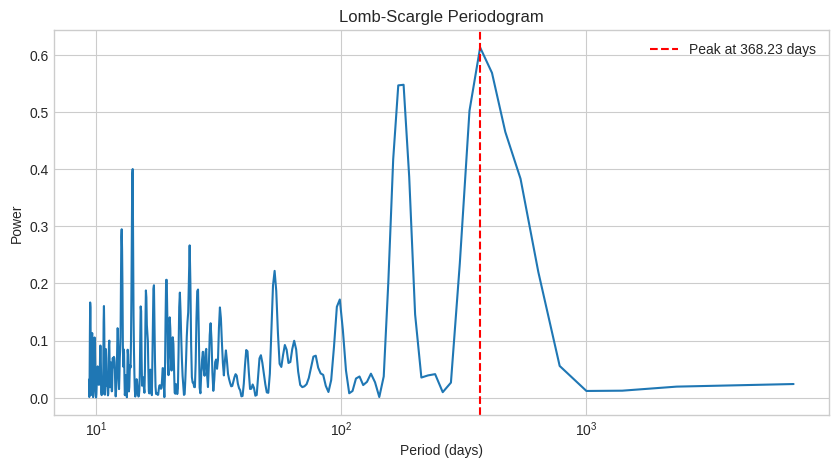

In [58]:
# Generate a Lomb-Scargle periodogram
frequency, power = LombScargle(t_obs, rv_obs, rv_err).autopower()
best_period = 1 / frequency[np.argmax(power)]

print(f"Best period from Lomb-Scargle: {best_period:.4f} days")

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(1 / frequency, power)
plt.axvline(best_period, color='r', linestyle='--', label=f'Peak at {best_period:.2f} days')
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
def solve_kepler(M, e):
    """Solves Kepler's equation M = E - e*sin(E) for E using Newton-Raphson."""
    # Initial guess for E can be M
    E = M
    # Iteratively solve for E
    for _ in range(10): # 10 iterations are usually more than enough
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        E = E - f / f_prime
    return E

def keplerian_model(t, P, K, e, omega, T0, Vsys):
    """Calculates radial velocity for a single planet Keplerian orbit."""
    # 1. Mean Anomaly
    M = 2 * np.pi / P * (t - T0)
    
    # 2. Solve Kepler's Equation for Eccentric Anomaly E
    E = solve_kepler(M, e)
    
    # 3. True Anomaly nu
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), 
                        np.sqrt(1 - e) * np.cos(E / 2))
    
    # 4. Model RV
    rv = Vsys + K * (np.cos(nu + omega) + e * np.cos(omega))
    return rv

In [60]:
# Initial guesses for the parameters [P, K, e, omega, T0, Vsys]
p0 = [
    best_period,                  # P (from periodogram)
    np.std(rv_obs),               # K (stdev of data is a rough guess)
    0.1,                          # e (start with a small eccentricity)
    np.pi/2,                      # omega (start at 90 degrees)
    t_obs[np.argmax(rv_obs)],     # T0 (time of max RV as a guess for periastron)
    np.mean(rv_obs)               # Vsys (mean of data)
]

# Set bounds to keep parameters physically plausible
bounds = (
    [0, 0, 0, 0, -np.inf, -np.inf], # Lower bounds
    [np.inf, np.inf, 0.99, 2*np.pi, np.inf, np.inf] # Upper bounds (e < 1)
)

# Perform the fit
popt, pcov = curve_fit(keplerian_model, t_obs, rv_obs, p0=p0, sigma=rv_err, bounds=bounds, maxfev=10000)

# Extract errors from the covariance matrix
perr = np.sqrt(np.diag(pcov))

## Best-Fit Orbital Parameters ##
P (Period)         = 367.2502 ± 4.2105 days
Kp (Semi-amplitude)= 0.13 ± 0.05 m/s
e (Eccentricity)   = 0.619 ± 0.135
w (Arg. Periastron)= 0.488 ± 0.172 rad (28.0 ± 9.9 deg)
To (Time Offset)   = 737.09 ± 5.84 days
Vsys (Systemic Vel)= 0.00 ± 0.01 m/s


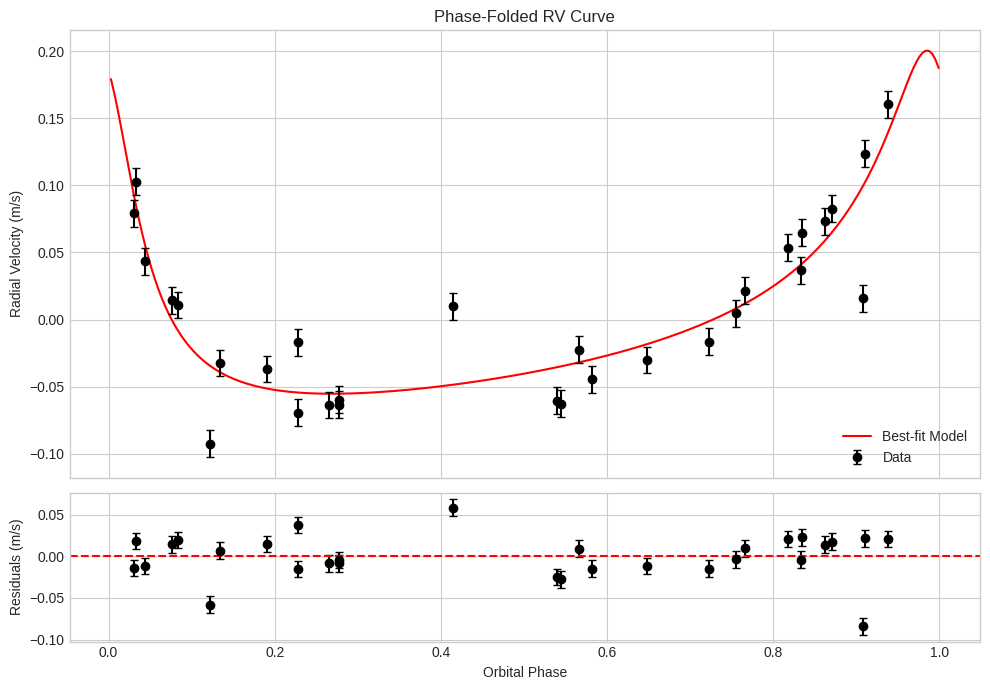

In [61]:
# Extract best-fit parameters
P_fit, K_fit, e_fit, omega_fit, T0_fit, Vsys_fit = popt
P_err, K_err, e_err, omega_err, T0_err, Vsys_err = perr

# --- Print Results ---
print("## Best-Fit Orbital Parameters ##")
print(f"P (Period)         = {P_fit:.4f} ± {P_err:.4f} days")
print(f"Kp (Semi-amplitude)= {K_fit:.2f} ± {K_err:.2f} m/s")
print(f"e (Eccentricity)   = {e_fit:.3f} ± {e_err:.3f}")
print(f"w (Arg. Periastron)= {omega_fit:.3f} ± {omega_err:.3f} rad ({np.rad2deg(omega_fit):.1f} ± {np.rad2deg(omega_err):.1f} deg)")
print(f"To (Time Offset)   = {T0_fit:.2f} ± {T0_err:.2f} days")
print(f"Vsys (Systemic Vel)= {Vsys_fit:.2f} ± {Vsys_err:.2f} m/s")


# --- Plotting ---
phase = (t_obs - T0_fit) / P_fit % 1.0

# Generate model curve for plotting
t_model = np.linspace(min(t_obs), max(t_obs), 500)
rv_model = keplerian_model(t_model, *popt)
phase_model = (t_model - T0_fit) / P_fit % 1.0

# Get residuals
residuals = rv_obs - keplerian_model(t_obs, *popt)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Phase-folded plot
sort_idx = np.argsort(phase_model)
ax1.plot(phase_model[sort_idx], rv_model[sort_idx], 'r-', label='Best-fit Model')
ax1.errorbar(phase, rv_obs, yerr=rv_err, fmt='ko', capsize=3, label='Data')
ax1.set_ylabel('Radial Velocity (m/s)')
ax1.set_title('Phase-Folded RV Curve')
ax1.legend()
ax1.grid(True)

# Residuals plot
ax2.errorbar(phase, residuals, yerr=rv_err, fmt='ko', capsize=3)
ax2.axhline(0, color='r', linestyle='--')
ax2.set_xlabel('Orbital Phase')
ax2.set_ylabel('Residuals (m/s)')
ax2.grid(True)

plt.tight_layout()
plt.savefig('keplerian_fit.pdf')
plt.show()

In [62]:
# --- Calculate Minimum Mass (Mp sin i) ---
# We use the best-fit parameters stored in 'popt'
P_fit, K_fit, e_fit, _, _, _ = popt

# --- Constants in SI units ---
G = 6.67430e-11         # Gravitational constant (m^3 kg^-1 s^-2)
M_sun_kg = 1.989e30     # Mass of the Sun (kg)
M_jupiter_kg = 1.898e27   # Mass of Jupiter (kg)

# --- Unit Conversions ---
P_fit_seconds = P_fit * 86400  # Convert period from days to seconds

# --- Calculation ---
# Rearrange the formula to solve for Mp*sin(i) in kg
term1 = K_fit
term2 = (P_fit_seconds / (2 * np.pi * G))**(1.0/3.0)
term3 = M_sun_kg**(2.0/3.0)
term4 = np.sqrt(1 - e_fit**2)

Mpsini_kg = term1 * term2 * term3 * term4

# Convert the final result to Jupiter masses for convenience
Mpsini_mjup = Mpsini_kg / M_jupiter_kg

# --- Print Results ---
print("## Planet Minimum Mass (Mp sin i) ##")
print(f"Assuming a solar-mass star (M* = 1.0 M_sun):")
print(f"-> Mp sin(i) = {Mpsini_kg:.3e} kg")
print(f"-> Mp sin(i) = {Mpsini_mjup:.3f} Jupiter Masses")

## Planet Minimum Mass (Mp sin i) ##
Assuming a solar-mass star (M* = 1.0 M_sun):
-> Mp sin(i) = 6.725e+24 kg
-> Mp sin(i) = 0.004 Jupiter Masses


# Question 2

In [42]:
spectrum_data = pd.read_csv('spectrum.csv') 
ch4_cross_section = pd.read_csv('xs_CH4_g395h.csv')
co2_cross_section = pd.read_csv('xs_CO2_g395h.csv')
h2o_cross_section = pd.read_csv('xs_H2O_g395h.csv')

In [52]:
spectrum_data.keys()

Index(['#wavelength (nm)', ' radius_ratio (rr)', ' error of rr (+)',
       ' error of rr (-)'],
      dtype='object')

--- Quantitative Fit Results ---
Baseline Offset: 0.1467
H₂O Coefficient: 2.37e+16
CO₂ Coefficient: 7.51e+14
CH₄ Coefficient: -3.24e+15


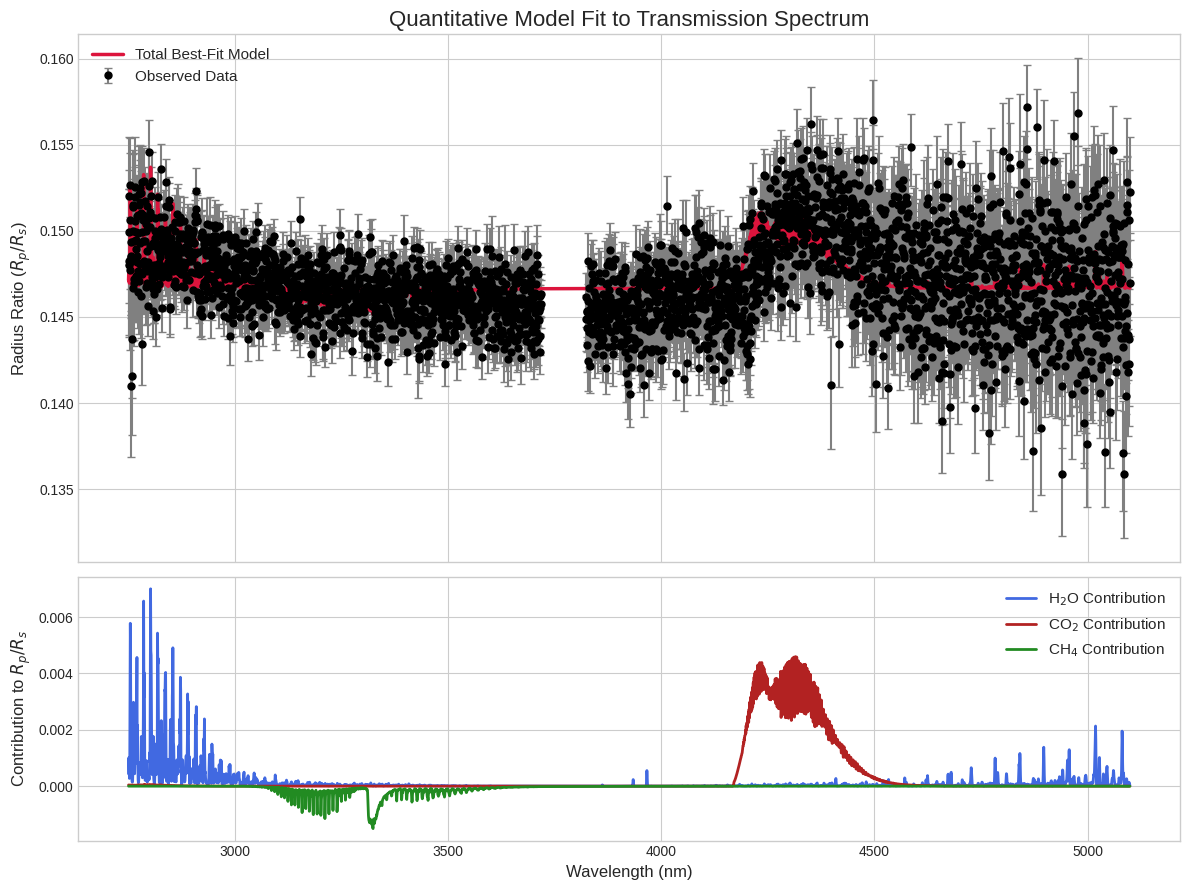

In [63]:
# --- 2. Prepare Data for a Linear Fit ---

# The target variable (y) is what we want to model.
y = spectrum_data[' radius_ratio (rr)']

# The features (X) are the molecular cross-sections that will form our model.
# We create a new DataFrame to hold them.
X = pd.DataFrame({
    'H2O': h2o_cross_section['0'],
    'CO2': co2_cross_section['0'],
    'CH4': ch4_cross_section['0']
})

# --- 3. Perform the Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# The 'predict' method gives the best-fit model for all data points.
total_model = lin_reg.predict(X)

# The coefficients tell us the contribution of each molecule.
h2o_coeff, co2_coeff, ch4_coeff = lin_reg.coef_
baseline = lin_reg.intercept_

print("--- Quantitative Fit Results ---")
print(f"Baseline Offset: {baseline:.4f}")
print(f"H₂O Coefficient: {h2o_coeff:.2e}")
print(f"CO₂ Coefficient: {co2_coeff:.2e}")
print(f"CH₄ Coefficient: {ch4_coeff:.2e}")

# --- 4. Visualize the Fit and Components ---

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 9), sharex=True, 
    gridspec_kw={'height_ratios': [2, 1]} # Make the top plot taller
)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Top Plot: Data vs. Best-Fit Model ---
ax1.set_title('Quantitative Model Fit to Transmission Spectrum', fontsize=16)
asymmetric_error = [spectrum_data[' error of rr (-)'], spectrum_data[' error of rr (+)']]
ax1.errorbar(
    spectrum_data['#wavelength (nm)'], 
    y, 
    yerr=asymmetric_error,
    fmt='o', color='black', markersize=5, ecolor='gray', capsize=3,
    label='Observed Data'
)
ax1.plot(
    spectrum_data['#wavelength (nm)'], 
    total_model, 
    color='crimson', lw=2.5, 
    label='Total Best-Fit Model'
)
ax1.set_ylabel('Radius Ratio ($R_p / R_s$)', fontsize=12)
ax1.legend(fontsize=11)

# --- Bottom Plot: Individual Molecular Contributions ---
# Calculate the contribution of each molecule to the spectrum's shape
h2o_contribution = h2o_coeff * X['H2O']
co2_contribution = co2_coeff * X['CO2']
ch4_contribution = ch4_coeff * X['CH4']

ax2.plot(spectrum_data['#wavelength (nm)'], h2o_contribution, color='royalblue', lw=2, label='H$_2$O Contribution')
ax2.plot(spectrum_data['#wavelength (nm)'], co2_contribution, color='firebrick', lw=2, label='CO$_2$ Contribution')
ax2.plot(spectrum_data['#wavelength (nm)'], ch4_contribution, color='forestgreen', lw=2, label='CH$_4$ Contribution')
ax2.set_ylabel('Contribution to $R_p / R_s$', fontsize=12)
ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.legend(fontsize=11)

# Final adjustments
plt.tight_layout()
plt.savefig('spectrum_analysis.pdf')
plt.show()